In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#import dataset67.65
user_df = pd.read_csv('data/User_SongFeatures_data.csv', compression="xz")

/Users/akashtc/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


For our model we will randomly split the dataset into three. There will be two test data sets and one validation dataset. The first data set will be used to perform matrix factorization to extract user and item latent factors. The second dataset will be used to train our classification model. And lastly, our validation set will be used to evaluate our model. 

In [2]:
# split into train, train 2 and validation set
# make sure users who have only listened once is in train set

song_count = user_df.groupby('user_id').count()[['song_id']].reset_index()
one_timers = song_count[song_count['song_id'] == 1]
len(one_timers)

3372

In [3]:
# subset data of users who only listened one time
one_df = user_df[user_df.user_id.isin(one_timers.user_id)]

In [4]:
# subset rest of data
df = user_df[~user_df.user_id.isin(one_timers.user_id)]
len(df)

1137044

In [5]:
X = df.drop('listen_count', axis=1)
y = df.listen_count

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=1)

In [7]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

409335
454818
272891


In [8]:
train1 = X_train.join(y_train).append(one_df, ignore_index=True)
train2 = X_test.join(y_test)
val = X_val.join(y_val)

/var/folders/km/dzl8bwrn3sv4v9_tbyy93vn4009q8p/T/ipykernel_94574/1307692615.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train1 = X_train.join(y_train).append(one_df, ignore_index=True)


In [9]:
print(len(train1))
print(len(train2))
print(len(val))

412707
454818
272891


In [10]:
# since there are songs with multiple ids with have to group by user id and song and sum the listen counts

train1_df = train1.groupby(['user_id','song'], as_index=False)['listen_count'].sum()
print(train1_df.user_id.nunique())
print(train1_df.song.nunique())

69327
5679


Before we perform non negative matrix factorization on our dataset we must first transform it into a matrix with user_id and song and the corresponding listen count. 

In [11]:
train1_df.head()

,user_id,song,listen_count
0,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,Ironmasters - The Men They Couldn't Hang,1
1,00030033e3a2f904a48ec1dd53019c9969b6ef1f,Chasing Cars - Snow Patrol,4
2,00030033e3a2f904a48ec1dd53019c9969b6ef1f,You'd Be So Nice To Come Home To - Julie London,1
3,0007235c769e610e3d339a17818a5708e41008d9,Dip It Low - Christina Milian,3
4,0007235c769e610e3d339a17818a5708e41008d9,Su veneno - Aventura,5


In [12]:
mf_df = train1_df.pivot(index = 'user_id', columns ='song', values = 'listen_count').fillna(0)
mf_df.head()

song,& Down - Boys Noize,' Cello Song - Nick Drake,'97 Bonnie & Clyde - Eminem,'Round Midnight - Amy Winehouse,(Antichrist Television Blues) - Arcade Fire,(I Just) Died In Your Arms - Cutting Crew,(If You're Wondering If I Want You To) I Want You To - Weezer,(Nice Dream) - Radiohead,(Sittin' On) The Dock Of The Bay - Otis Redding,(The Symphony Of) Blase' - Anberlin,...,and then patterns - Four Tet,clouding - Four Tet,high fives - Four Tet,in white rooms - Booka Shade,mOBSCENE - Marilyn Manson,paranoid android - Christopher O'Riley,smile around the face - Four Tet,sun drums and soil - Four Tet,the Love Song - K-OS,you were there with me - Four Tet
user_id,,,,,,,,,,,,,,,,,,,,,
00005c6177188f12fb5e2e82cdbd93e8a3f35e64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00030033e3a2f904a48ec1dd53019c9969b6ef1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007235c769e610e3d339a17818a5708e41008d9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000a5c8b4d8b2c98f7a205219181d039edcd4506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000b474f815bcff17a4bc9ce5324f9352dafe07d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# turn into matrix

mf_df = mf_df.values

We will now perform non negative matrix factorization to extract latent factors from our matrix.

In [57]:
from sklearn.decomposition import NMF

model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(mf_df)
H = model.components_

/Users/akashtc/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [15]:
W.shape

(69327, 10)

In [16]:
W

array([[1.76406649e-04, 1.26334459e-05, 4.21730345e-06, ...,
        0.00000000e+00, 0.00000000e+00, 9.03076825e-10],
       [1.59030466e-02, 1.83123563e-04, 0.00000000e+00, ...,
        2.75267919e-05, 0.00000000e+00, 6.72320226e-06],
       [6.30621595e-04, 0.00000000e+00, 0.00000000e+00, ...,
        3.04965801e-04, 0.00000000e+00, 2.51825023e-07],
       ...,
       [3.91709927e-04, 8.22175128e-05, 4.45082817e-04, ...,
        6.76004076e-06, 1.55965901e-06, 3.57313070e-06],
       [7.47543623e-03, 1.50371664e-04, 0.00000000e+00, ...,
        5.35782068e-04, 0.00000000e+00, 2.21047711e-05],
       [6.02249602e-04, 7.79133239e-05, 9.22752750e-05, ...,
        3.47810032e-05, 0.00000000e+00, 2.04933768e-06]])

In [17]:
H

array([[2.05173468e-03, 3.72554583e-04, 1.21308754e-04, ...,
        1.43279580e-04, 1.00880594e-04, 5.27087394e-05],
       [8.44829482e-05, 3.67466502e-05, 0.00000000e+00, ...,
        1.50170714e-05, 2.51045730e-05, 0.00000000e+00],
       [1.81244267e-05, 4.54633124e-06, 0.00000000e+00, ...,
        9.96913824e-06, 1.70616582e-06, 5.05505888e-06],
       ...,
       [6.78647879e-04, 1.02688872e-04, 7.43336100e-03, ...,
        4.04644396e-06, 6.80778739e-06, 4.75168514e-06],
       [5.94316770e-05, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.67954754e-05, 1.62993919e-05, 7.07420210e-06, ...,
        2.57225491e-06, 4.05475741e-06, 2.62098530e-06]])

In [18]:
import numpy as np

user = pd.DataFrame(W, columns = ['u1','u2','u3','u4','u5','u6','u7', 'u8', 'u9', 'u10'])

song = pd.DataFrame(H).transpose()


In [19]:
user.head()

,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10
0,0.000176,0.000013,0.000004,3.381426e-07,3.229037e-06,0.000050,4.527343e-07,0.000000,0.0,9.030768e-10
1,0.015903,0.000183,0.000000,0.000000e+00,2.856881e-04,0.000280,0.000000e+00,0.000028,0.0,6.723202e-06
2,0.000631,0.000000,0.000000,8.018646e-04,0.000000e+00,0.000299,1.841464e-04,0.000305,0.0,2.518250e-07
3,0.000041,0.000002,0.000004,2.136306e-07,7.172430e-07,0.000003,1.167560e-06,0.000000,0.0,9.109420e-08
4,0.000439,0.000016,0.000046,9.357967e-05,7.511529e-06,0.000109,2.644372e-06,0.000000,0.0,3.931286e-06


In [20]:
train1_df.user_id.unique()

array(['00005c6177188f12fb5e2e82cdbd93e8a3f35e64',
       '00030033e3a2f904a48ec1dd53019c9969b6ef1f',
       '0007235c769e610e3d339a17818a5708e41008d9', ...,
       'fffd9635b33f412de8ed02e44e6564e3644cf3c6',
       'fffe6d1d8500f1c1f31bd63abce35c0f975a86bf',
       'fffea3d509760c984e7d40789804c0e5e289cc86'], dtype=object)

Now we will append the user and song latent factors found to our original dataset. 

In [21]:
# add latent factors as new columns

user_factors = pd.DataFrame(train1_df.user_id.unique()).join(user)
user_factors.columns = ['user_id','u1','u2','u3','u4','u5','u6','u7', 'u8', 'u9', 'u10']

user_factors.head()


,user_id,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10
0,00005c6177188f12fb5e2e82cdbd93e8a3f35e64,0.000176,0.000013,0.000004,3.381426e-07,3.229037e-06,0.000050,4.527343e-07,0.000000,0.0,9.030768e-10
1,00030033e3a2f904a48ec1dd53019c9969b6ef1f,0.015903,0.000183,0.000000,0.000000e+00,2.856881e-04,0.000280,0.000000e+00,0.000028,0.0,6.723202e-06
2,0007235c769e610e3d339a17818a5708e41008d9,0.000631,0.000000,0.000000,8.018646e-04,0.000000e+00,0.000299,1.841464e-04,0.000305,0.0,2.518250e-07
3,000a5c8b4d8b2c98f7a205219181d039edcd4506,0.000041,0.000002,0.000004,2.136306e-07,7.172430e-07,0.000003,1.167560e-06,0.000000,0.0,9.109420e-08
4,000b474f815bcff17a4bc9ce5324f9352dafe07d,0.000439,0.000016,0.000046,9.357967e-05,7.511529e-06,0.000109,2.644372e-06,0.000000,0.0,3.931286e-06


In [22]:
song_factors = pd.DataFrame(train1_df.song.unique(), columns = ['song']).join(song)
song_factors.columns = ['song','s1','s2','s3','s4','s5','s6','s7', 's8', 's9', 's10']
song_factors.head()


,song,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,Ironmasters - The Men They Couldn't Hang,0.002052,0.000084,0.000018,0.000240,0.000162,0.001347,0.000150,0.000679,0.000059,0.000037
1,Chasing Cars - Snow Patrol,0.000373,0.000037,0.000005,0.000087,0.000051,0.000228,0.000025,0.000103,0.000000,0.000016
2,You'd Be So Nice To Come Home To - Julie London,0.000121,0.000000,0.000000,0.000015,0.000028,0.000366,0.000041,0.007433,0.000000,0.000007
3,Dip It Low - Christina Milian,0.000568,0.000052,0.000016,0.000008,0.000023,0.000327,0.000140,0.000217,0.000179,0.000014
4,Su veneno - Aventura,0.001504,0.000007,0.000039,0.000015,0.000434,0.000680,0.000021,0.000341,0.000159,0.000029


In [23]:
train2_df = pd.merge(train2, user_factors, on='user_id')

In [24]:
train2_df = pd.merge(train2_df, song_factors, on='song')

In [25]:
len(train2_df)

442164

In [26]:
train2_df.head()

,user_id,song_id,title,release,artist_name,year,song,id,name,uri_x,...,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,25fb6b52eb2f3bb6e137dec0f08dcbebdcd5a15e,SOKFYFE12A6701D104,moon baby,Godsmack,godsmack,1997,Moon Baby - Godsmack,7fujLGyPh3b45OwjFhlQ8Q,moon baby,spotify:track:7fujLGyPh3b45OwjFhlQ8Q,...,0.001249,0.0,0.000199,0.000005,0.000738,0.000378,0.00025,0.000086,0.0,0.000038
1,ba5ad397b841ef2ad9db46ab041e0f0c5bc06a86,SOKFYFE12A6701D104,moon baby,Godsmack,godsmack,1997,Moon Baby - Godsmack,7fujLGyPh3b45OwjFhlQ8Q,moon baby,spotify:track:7fujLGyPh3b45OwjFhlQ8Q,...,0.001249,0.0,0.000199,0.000005,0.000738,0.000378,0.00025,0.000086,0.0,0.000038
2,da5d0afc724e7d63b9e90552a4d148fcce94e97e,SOKFYFE12A6701D104,moon baby,Godsmack,godsmack,1997,Moon Baby - Godsmack,7fujLGyPh3b45OwjFhlQ8Q,moon baby,spotify:track:7fujLGyPh3b45OwjFhlQ8Q,...,0.001249,0.0,0.000199,0.000005,0.000738,0.000378,0.00025,0.000086,0.0,0.000038
3,e180f1bf6db0511fa971e50695017b30a0df6cf5,SOKFYFE12A6701D104,moon baby,Godsmack,godsmack,1997,Moon Baby - Godsmack,7fujLGyPh3b45OwjFhlQ8Q,moon baby,spotify:track:7fujLGyPh3b45OwjFhlQ8Q,...,0.001249,0.0,0.000199,0.000005,0.000738,0.000378,0.00025,0.000086,0.0,0.000038
4,b34e46ffab91c0fb5e24e4cf261e09034cc2f625,SOKFYFE12A6701D104,moon baby,Godsmack,godsmack,1997,Moon Baby - Godsmack,7fujLGyPh3b45OwjFhlQ8Q,moon baby,spotify:track:7fujLGyPh3b45OwjFhlQ8Q,...,0.001249,0.0,0.000199,0.000005,0.000738,0.000378,0.00025,0.000086,0.0,0.000038


In [27]:
train2_df.columns

Index(['user_id', 'song_id', 'title', 'release', 'artist_name', 'year', 'song',
       'id', 'name', 'uri_x', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'uri_y', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'listen_count', 'u1', 'u2', 'u3', 'u4',
       'u5', 'u6', 'u7', 'u8', 'u9', 'u10', 's1', 's2', 's3', 's4', 's5', 's6',
       's7', 's8', 's9', 's10'],
      dtype='object')

In [28]:
df.listen_count.describe()

count    1.137044e+06
mean     2.875238e+00
std      6.163442e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.213000e+03
Name: listen_count, dtype: float64

Since this is a classification problem, we will transform listen_count into labels of 'one' and 'one_plus'.

In [29]:
def f(row):
    if  row['listen_count'] == 1:
        val = 0
    else:
        val = 1
    return val

In [30]:
train2_df['label'] = train2_df.apply(f, axis=1)

In [31]:
# extract relevant columns for classification

train2_X = train2_df[['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature','valence','s1', 's2', 's3', 's4', 's5', 's6','s7','s8', 's9', 's10', 'u1','u2','u3','u4','u5','u6','u7','u8', 'u9', 'u10']]

In [32]:
len(train2_X)

442164

In [33]:
# extract labels
train2_y = train2_df['label']

In [34]:
# merge user and song latent factors to validation set

val_df = pd.merge(val, user_factors, on='user_id')
val_df = pd.merge(val_df, song_factors, on='song')
val_df['label'] = val_df.apply(f, axis=1)

In [35]:
val_X = val_df[['acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo', 'time_signature','valence','s1', 's2', 's3', 's4', 's5', 's6','s7','s8', 's9', 's10', 'u1','u2','u3','u4','u5','u6','u7','u8', 'u9', 'u10']]

In [36]:
val_X.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10
0,0.0142,0.673,192333,0.607,0.000004,5,0.333,-7.672,1,0.027,...,0.526464,0.028890,0.006664,0.046162,0.001386,0.160497,0.015893,0.013152,0.000114,0.001658
1,0.0142,0.673,192333,0.607,0.000004,5,0.333,-7.672,1,0.027,...,0.492856,0.002701,0.000420,0.002362,0.002357,0.029457,0.002199,0.001090,0.002095,0.000148
2,0.0142,0.673,192333,0.607,0.000004,5,0.333,-7.672,1,0.027,...,0.019042,0.000428,0.000391,0.000075,0.000180,0.002661,0.000242,0.000306,0.000000,0.000054
3,0.0142,0.673,192333,0.607,0.000004,5,0.333,-7.672,1,0.027,...,0.004786,0.000390,0.000053,0.006192,0.000137,0.000690,0.000787,0.000560,0.000000,0.000019
4,0.0142,0.673,192333,0.607,0.000004,5,0.333,-7.672,1,0.027,...,0.074593,0.002298,0.000184,0.000000,0.000000,0.005310,0.000319,0.000203,0.000000,0.000000


In [37]:
train2_X.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10
0,0.000046,0.257,263133,0.906,0.00146,6,0.746,-6.843,0,0.112,...,0.001435,0.000023,3.733389e-07,0.000012,0.000003,0.000317,0.000004,0.000007,0.000000,0.000001
1,0.000046,0.257,263133,0.906,0.00146,6,0.746,-6.843,0,0.112,...,0.004067,0.000304,7.946484e-03,0.000073,0.000004,0.000941,0.000270,0.000145,0.000003,0.000003
2,0.000046,0.257,263133,0.906,0.00146,6,0.746,-6.843,0,0.112,...,0.044587,0.000000,0.000000e+00,0.000000,0.000000,0.903068,0.003577,0.000000,0.000000,0.000009
3,0.000046,0.257,263133,0.906,0.00146,6,0.746,-6.843,0,0.112,...,0.009367,0.000428,1.556319e-04,0.000146,0.000135,0.001147,0.000122,0.000265,0.000000,0.000115
4,0.000046,0.257,263133,0.906,0.00146,6,0.746,-6.843,0,0.112,...,0.129632,0.001646,1.744126e-05,0.000000,0.000000,0.078708,0.000000,0.000287,0.000000,0.000000


In [38]:
val_y = val_df['label']
val_y

0         1
1         0
2         0
3         0
4         1
         ..
265281    0
265282    0
265283    0
265284    1
265285    0
Name: label, Length: 265286, dtype: int64

Now we will train XGBoost.

In [39]:
#XGBOOST TRAINING ACCURACY

from xgboost import XGBClassifier
from sklearn.metrics import (classification_report,confusion_matrix, accuracy_score, f1_score, roc_auc_score)

xgb = XGBClassifier()
xgb.fit(train2_X, train2_y)
xgb_pred = xgb.predict(train2_X)
y_pred = xgb.predict_proba(train2_X)[:,1]


print('\n Confusion Matrix:\n',confusion_matrix(train2_y,xgb_pred))
print("\n Classification Report: \n", classification_report(train2_y, xgb_pred))
print("Accuracy:", (accuracy_score(train2_y,xgb_pred)))
print("AUC Score:", (roc_auc_score(train2_y,y_pred)))


 Confusion Matrix:
 [[222225  34654]
 [117530  67755]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.87      0.74    256879
           1       0.66      0.37      0.47    185285

    accuracy                           0.66    442164
   macro avg       0.66      0.62      0.61    442164
weighted avg       0.66      0.66      0.63    442164

Accuracy: 0.6558200124840556
AUC Score: 0.6994024700970669


In [40]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [41]:
# XGBoost TEST accuracy
xgb_pred2 = xgb.predict(val_X)
y_pred2 = xgb.predict_proba(val_X)[:,1]

print('\n Confusion Matrix:\n',confusion_matrix(val_y,xgb_pred2))
print("\n Classification Report: \n", classification_report(val_y, xgb_pred2))
print("Accuracy:", (accuracy_score(val_y,xgb_pred2)))
print("AUC Score:", (roc_auc_score(val_y,y_pred2)))



 Confusion Matrix:
 [[130049  24361]
 [ 74051  36825]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.84      0.73    154410
           1       0.60      0.33      0.43    110876

    accuracy                           0.63    265286
   macro avg       0.62      0.59      0.58    265286
weighted avg       0.62      0.63      0.60    265286

Accuracy: 0.6290343252188204
AUC Score: 0.6530506381793364


### Feature Importance

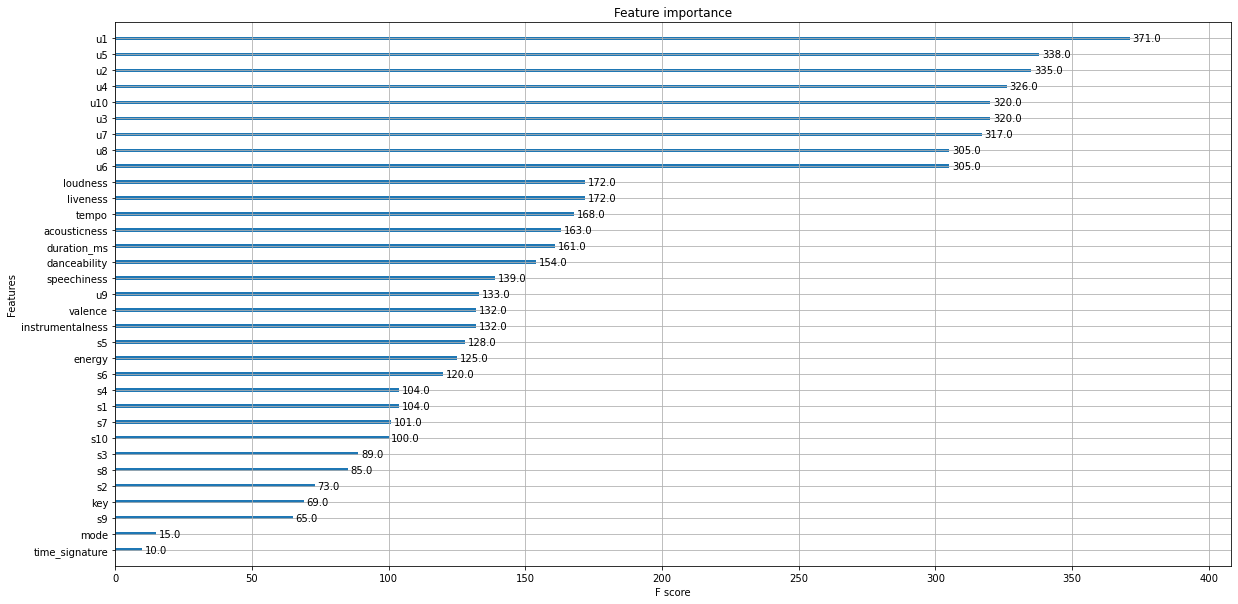

In [68]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(xgb)
plt.rcParams["figure.figsize"] = (50,10)
plt.show()


In [43]:
## remove least important features 

xgb_f = XGBClassifier()
xgb_f.fit(train2_X.drop(['mode','s8', 'time_signature','s6','s2', 's4','s5','s1','key'], axis = 1), train2_y)

xgb_pred2 = xgb_f.predict(val_X.drop(['mode','s8', 'time_signature','s6', 's2','s4','s5','s1','key'], axis = 1))
y_pred2 = xgb_f.predict_proba(val_X.drop(['mode','s8', 'time_signature', 's6', 's2','s4','s5','s1','key'], axis = 1))[:,1]

print('\n Confusion Matrix:\n',confusion_matrix(val_y,xgb_pred2))
print("\n Classification Report: \n", classification_report(val_y, xgb_pred2))
print("Accuracy:", (accuracy_score(val_y,xgb_pred2)))
print("AUC Score:", (roc_auc_score(val_y,y_pred2)))


 Confusion Matrix:
 [[130613  23797]
 [ 74385  36491]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.85      0.73    154410
           1       0.61      0.33      0.43    110876

    accuracy                           0.63    265286
   macro avg       0.62      0.59      0.58    265286
weighted avg       0.62      0.63      0.60    265286

Accuracy: 0.629901314053512
AUC Score: 0.652051562701781


Now we will play with the hyperparameter to see if we can increase AUC. 

In [44]:


xgb2 = XGBClassifier(subsample=0.6, colsample_bytree=0.6, max_depth=8, learning_rate=0.01, n_estimators=1000 )
xgb2.fit(train2_X.drop(['mode','s8', 'time_signature','s6','s2', 's4','s5','s1','key'], axis = 1), train2_y)
xgb_pred3 = xgb2.predict(val_X.drop(['mode','s8', 'time_signature','s6', 's2','s4','s5','s1','key'], axis = 1))
y_pred3 = xgb2.predict_proba(val_X.drop(['mode','s8', 'time_signature','s6', 's2','s4','s5','s1','key'], axis = 1))[:,1]


print('\n Confusion Matrix:\n',confusion_matrix(val_y,xgb_pred3))
print("\n Classification Report: \n", classification_report(val_y, xgb_pred3))
print("Accuracy:", (accuracy_score(val_y,xgb_pred3)))
print("AUC Score:", (roc_auc_score(val_y,y_pred3)))


 Confusion Matrix:
 [[135050  19360]
 [ 78215  32661]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.87      0.73    154410
           1       0.63      0.29      0.40    110876

    accuracy                           0.63    265286
   macro avg       0.63      0.58      0.57    265286
weighted avg       0.63      0.63      0.60    265286

Accuracy: 0.6321894106737634
AUC Score: 0.6567410252879239


In [45]:
train2_X = train2_X.drop(['mode','s8', 'time_signature','s6','s2', 's4','s5','s1','key'], axis = 1)
val_X = val_X.drop(['mode','s8', 'time_signature','s6','s2', 's4','s5','s1','key'], axis = 1)

Now lets train Random Forest.

In [46]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier()
rfclf.fit(train2_X, train2_y)

y_pred = rfclf.predict(val_X)
class_pred = rfclf.predict_proba(val_X)[:,1]

print('\n Confusion Matrix:\n',confusion_matrix(val_y,y_pred))
print("\n Classification Report: \n", classification_report(val_y, y_pred))
print("Accuracy:", (accuracy_score(val_y,y_pred)))
print("AUC Score:", (roc_auc_score(val_y,class_pred)))


 Confusion Matrix:
 [[127656  26754]
 [ 68321  42555]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.83      0.73    154410
           1       0.61      0.38      0.47    110876

    accuracy                           0.64    265286
   macro avg       0.63      0.61      0.60    265286
weighted avg       0.64      0.64      0.62    265286

Accuracy: 0.641613202355194
AUC Score: 0.6694239679609693


In [47]:
rfclf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Tune hyperparameters to see if we can increase AUC.

In [48]:
rfclf2 = RandomForestClassifier(n_estimators=100)
rfclf2.fit(train2_X, train2_y)
y_pred2 = rfclf2.predict(val_X)
class_pred2 = rfclf2.predict_proba(val_X)[:,1]

print('\n Confusion Matrix:\n',confusion_matrix(val_y,y_pred2))
print("\n Classification Report: \n", classification_report(val_y, y_pred2))
print("Accuracy:", (accuracy_score(val_y,y_pred2)))
print("AUC Score:", (roc_auc_score(val_y,class_pred2)))


 Confusion Matrix:
 [[127713  26697]
 [ 68472  42404]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.83      0.73    154410
           1       0.61      0.38      0.47    110876

    accuracy                           0.64    265286
   macro avg       0.63      0.60      0.60    265286
weighted avg       0.64      0.64      0.62    265286

Accuracy: 0.6412588677879723
AUC Score: 0.6689228390760373


Ensemble our RF and XGBoost models by averaging probabilities. 

In [49]:
## average probabilities of two models

# get probabilities of random forest binary classifier
x = xgb2.predict_proba(val_X)

# get probabilities of SVM binary classifier
r = rfclf2.predict_proba(val_X)

In [50]:
#add index to probabilities so we can merge
x = pd.DataFrame(data=x, index=val_X.index)
r = pd.DataFrame(data=r, index=val_X.index)


# build a dataframe of probabilities (averaged)
P = pd.DataFrame(index=val_X.index)
for i in P.index:
    try:
        P.loc[i,0] = (x.loc[i,0] + r.loc[i,0])/2
        P.loc[i,1] = (x.loc[i,1] + r.loc[i,1])/2
    except KeyError:
        P.loc[i,:] = x.loc[i,:]

In [51]:
P

,0,1
0,0.529085,0.470915
1,0.693118,0.306882
2,0.639560,0.360440
3,0.567051,0.432949
4,0.566295,0.433705
...,...,...
265281,0.561010,0.438990
265282,0.688953,0.311047
265283,0.440299,0.559701
265284,0.500411,0.499589


In [52]:
val_y.head()

0    1
1    0
2    0
3    0
4    1
Name: label, dtype: int64

Now lets see if the ensemble increases our AUC.

In [53]:
# get new auc score
def pred_class(row):
    if row[1] > row[0]:
        return 1
    else:
        return 0

P['pred'] = P.apply(lambda row: pred_class(row), axis =1)
new_pred_y = P['pred']

print('\n Confusion Matrix:\n',confusion_matrix(val_y,new_pred_y))
print("\n Classification Report: \n", classification_report(val_y, new_pred_y))
print("Accuracy:", (accuracy_score(val_y,new_pred_y)))
print("AUC Score:", (roc_auc_score(val_y,P[1])))


 Confusion Matrix:
 [[133072  21338]
 [ 73177  37699]]

 Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.86      0.74    154410
           1       0.64      0.34      0.44    110876

    accuracy                           0.64    265286
   macro avg       0.64      0.60      0.59    265286
weighted avg       0.64      0.64      0.61    265286

Accuracy: 0.6437241316918345
AUC Score: 0.6756835418963156


Now we will write a function that will print out top 10 songs for a user

In [54]:
def get_top_songs(user_id):
    
    # get songs user has listened to 
    listened_songs = train2_df[train2_df.user_id == user_id].song.unique()
    
    # get songs user has not listened to 
    songs = train2_df.drop(columns=['user_id','listen_count']).drop_duplicates('song')
    not_listened = songs[~songs.song.isin(listened_songs)].drop(columns=['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7','label'])
    not_listened['user_id'] = user_id
    
    # join user features and song features on songs not listened to
    not_listened_df = not_listened.merge(user_factors, on = 'user_id')
    
    
    # add probabilities of belonging to class 'one_plus'
    not_listened_df['pred']= P.iloc[:,1]
    
    # get top 10 predictions
    top_pred = not_listened_df.sort_values(by ='pred', ascending=False).head(5)
    return top_pred[['song_id', 'song', 'pred']]

In [55]:
get_top_songs('f1ccb26d0d49490016747f6592e6f7b1e53a9e54')

,song_id,song,pred
3556,SOTHNRN12A8C143963,Fallin' Apart - The All-American Rejects,0.915466
1524,SOTRQEJ12AF72A45D7,Spies - Coldplay,0.900136
1526,SOWSZBE12AB01830DE,The Legionnaire's Lament - The Decemberists,0.896441
2805,SODKJWI12A8151BD74,From The Ritz To The Rubble - Arctic Monkeys,0.868117
2552,SOCATCA12AB0181E75,Dragon Queen - Yeah Yeah Yeahs,0.838229


In [56]:
train2_df[train2_df.user_id == 'f1ccb26d0d49490016747f6592e6f7b1e53a9e54'].sort_values(by='listen_count', ascending=False)[['song','listen_count','label']]

,song,listen_count,label
338836,Woods - Bon Iver,6,1
267435,Creature Fear - Bon Iver,6,1
358035,Lonelily - Damien Rice,4,1
155277,Blindsided - Bon Iver,4,1
92315,Coconut Skins - Damien Rice,3,1
173111,Blood Bank - Bon Iver,3,1
267208,Flume - Bon Iver,3,1
409206,Beach Baby - Bon Iver,2,1
227613,The Animals Were Gone - Damien Rice,2,1
394799,Grey Room - Damien Rice,2,1
